# GAN Explorations

-- Steven Larsen, Nick Larsen

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torch.nn.functional as F

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torchgan

# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    #generator.cuda()
    #discriminator.cuda()
    #adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor


In [2]:
def imshow(img):
    # custom show in order to display
    # torch tensors as numpy
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [3]:
dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified


In [4]:
batch_size = 250

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

In [5]:

dataiter = iter(dataloader)
real_image_examples, classes = dataiter.next()

In [6]:
latent_dim = 32
height = 32
width = 32
channels = 3
ohe_embedded_dim = 8
n_classes = len(classes)

In [13]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        
        # Set up the ohe -> FC 256
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, ohe_embedded_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )
    
        # First, transform the input into a 8x8 256-channels feature map
        self.init_size = width // 8  # one eighth the image size 
        self._latent_dim = latent_dim
        self.l1 = nn.Sequential(
            nn.Linear(self._latent_dim + ohe_embedded_dim, 
                      256 * self.init_size ** 2))   #4X4
        self.conv_blocks = nn.Sequential(
            #input 256 X init_size X init_size
            
            ############# 4x4 #########################################
            nn.BatchNorm2d(256), 
            nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2, inplace=True), 
            
            nn.BatchNorm2d(256), 
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), #8X8
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 8X8 #########################################
            
            nn.BatchNorm2d(128), 
            nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.BatchNorm2d(128), 
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 16X16 #########################################
            
            nn.BatchNorm2d(64), 
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.BatchNorm2d(64), 
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            
            ############# 32X32 #########################################
            
            # Produce a 32x32xRGB-channel feature map
            nn.Conv2d(32, channels, kernel_size=3, padding='same'),
            nn.Tanh(),
        )
        
    def forward(self, z, ohe):
        #add the ohe input
        out_ohe = self.ohe_fc(ohe)
        z = torch.cat((z, out_ohe), dim=1)
        
        # expand the sampled z to 8x8
        out = self.l1(z)
        
        out = torch.reshape(out, (out.shape[0], 256, self.init_size, self.init_size))
        
        # use the view function to reshape the layer output
        #  old way for earlier Torch versions: out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [8]:
gen = Generator(latent_dim)
gen = gen.to(device)

In [9]:
random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (32, latent_dim))))
random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, 32)]))
generated_images = gen(random_latent_vectors, random_ohe)

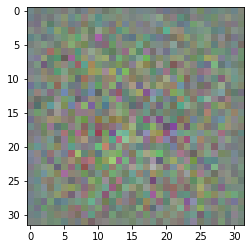

In [10]:
imshow(generated_images[1].detach().cpu())

In [14]:
class Discriminator(nn.Module):

    def __init__(self, latent_dim):
        super(Discriminator, self).__init__()
        
        self.init_size = width // 8  # one eighth the image size 
        self._latent_dim = latent_dim
        
        self.ohe_fc = nn.Sequential(
            nn.Linear(n_classes, 16),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.model = nn.Sequential(
            
            ############# 32X32 #########################################
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'), #32X32
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32, 0.8),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1), #16X16
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            ############# 16X16 #########################################
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(64, 0.8),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1), #8x8
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            ############# 8X8 #########################################
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(128, 0.8),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1), #4X4
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
            
            ############# 4x4 #########################################
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(256, 0.8),
        )
        
        # laten_dim_layer layer
        self.laten_dim_layer = nn.Sequential(nn.Linear(256 * self.init_size ** 2 + 16, self._latent_dim), 
                                                  nn.Sigmoid())
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(self._latent_dim + 16, 1), 
                                                  nn.Sigmoid())
    def forward(self, img, ohe):
        out_ohe = self.ohe_fc(ohe)
        
        out = self.model(img)
        # use the view function to flatten the layer output
        #    old way for earlier Torch versions: out = out.view(out.shape[0], -1)
        out = torch.flatten(out, start_dim=1) # don't flatten over batch size
        
        # move to the latent dim
        out = torch.cat((out, out_ohe), dim=1)
        out = self.laten_dim_layer(out)
        
        #validate the latent dim
        out = torch.cat((out, out_ohe), dim=1)
        validity = self.classification_layer(out)
        return validity


In [12]:
disc = Discriminator(latent_dim).to(device)

In [13]:
disc(generated_images, random_ohe)

tensor([[0.4863],
        [0.4816],
        [0.4782],
        [0.4819],
        [0.4783],
        [0.4815],
        [0.4810],
        [0.4778],
        [0.4797],
        [0.4809],
        [0.4820],
        [0.4803],
        [0.4831],
        [0.4778],
        [0.4797],
        [0.4778],
        [0.4834],
        [0.4821],
        [0.4784],
        [0.4818],
        [0.4784],
        [0.4823],
        [0.4806],
        [0.4787],
        [0.4820],
        [0.4816],
        [0.4831],
        [0.4801],
        [0.4788],
        [0.4788],
        [0.4799],
        [0.4770]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [14]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

In [18]:
log_every = 100


# code is the exact same as above, no need to change it
# because we have changed the adversarial loss function
# Start training loop

# Becasue not much is changing, an interesting update would
# be to write a "train step" function and use it here.
# Something like: train_step(g, d, imgs, loss_select=MSE, num_d_steps=1)

class_mappings = {
    3: 0,
    5: 1,
}

def train(generator, gan_optimizer,
          discriminator, discriminator_optimizer,
          iterations, dataloader, begin_step=None
          
    ):
    total_steps = 0
    if begin_step is not None:
        total_steps = begin_step

    for step in range(iterations):
        total_steps = total_steps+1

        for i, (imgs, classes) in enumerate(dataloader):

            # Get the OHE of the imgs we used.
            #classes.apply_(lambda c: class_mappings[c])
            ohe = F.one_hot(classes, num_classes=n_classes).to(device)
            ohe = ohe.float()

            #===================================
            # GENERATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            gan_optimizer.zero_grad()

            random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, imgs.shape[0])]))
            # Sample random points in the latent space
            random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
            # Decode them to fake images, through the generator
            generated_images = generator(random_latent_vectors, random_ohe)

            # Assemble labels that say "all real images"
            # misleading target, c=1
            misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

            # Get MSE Loss function
            # want generator output to generate images that are "close" to all "ones" 
            g_loss = adversarial_loss(discriminator(generated_images, random_ohe), misleading_targets)

            # now back propagate to get derivatives
            g_loss.backward()

            # use gan optimizer to only update the parameters of the generator
            # this was setup above to only use the params of generator
            gan_optimizer.step()

            #===================================
            # DISCRIMINATOR OPTIMIZE AND GET LABELS

            # Zero out any previous calculated gradients
            discriminator_optimizer.zero_grad()

            # Combine real images with some generator images
            real_images = Variable(imgs.type(Tensor))
            combined_images = torch.cat([real_images, generated_images.detach()])
            # in the above line, we "detach" the generated images from the generator
            # this is to ensure that no needless gradients are calculated 
            # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
            # but they would be calculated here, which wastes time.

            # Assemble labels discriminating real from fake images
            # real label, a=1 and fake label, b=0
            labels = torch.cat((
                Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
                Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
            ))
            # Add random noise to the labels - important trick!
            labels += 0.05 * torch.rand(labels.shape).to(device)

            # Setup Discriminator loss
            # this takes the average of MSE(real images labeled as real) + MSE(fake images labeled as fake)
            d_loss = (
                adversarial_loss(discriminator(combined_images[:batch_size], ohe), labels[:batch_size]) + \
                adversarial_loss(discriminator(combined_images[batch_size:], random_ohe), labels[batch_size:])
                ) / 2

            # get gradients according to loss above
            d_loss.backward()
            # optimize the discriminator parameters to better classify images
            discriminator_optimizer.step()

            # Now Clip weights of discriminator (manually)
            for p in discriminator.parameters():
                p.data.clamp_(-clip_value, clip_value)

            #===================================
        
        # Occasionally save / plot
        if step % log_every == 0:
            # Print metrics
            print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
            # save images in a list for display later
            
            with torch.no_grad():
                fake_output = generator(fixed_random_latent_vectors, fixed_ohe).detach().cpu()
            img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))

            # in addition, save off a checkpoint of the current models and images
            ims = np.array([np.transpose(np.hstack((i,real_image_numpy)), (2,1,0)) for i in img_list])
            np.save('models/gan_models/plain_images.npy',ims)

            # save the state of the models (will need to recreate upon reloading)
            torch.save({'state_dict': generator.state_dict()}, 'models/gan_models/ls_gen.pth')
            torch.save({'state_dict': discriminator.state_dict()}, 'models/gan_models/ls_dis.pth')
    return (ims)

In [21]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

# LSGAN says they use ADAM, but follow up papers say RMSProp is lsightly better
#lr = 0.0002
#betas = (0.5, 0.999)

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
        
# set discriminator learning higher than generator
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),
                                              lr=0.0002, weight_decay=1e-8)

gan_optimizer = torch.optim.RMSprop(generator.parameters(),
                                    lr=0.0001, weight_decay=1e-8)

# used to be: adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
adversarial_loss = torch.nn.MSELoss() # mean squared error loss 

generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (ohe_fc): Sequential(
    (0): Linear(in_features=250, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(128, eps=0.8, momentum=0.1

In [23]:
%%time
"""
Train the Vanilla GAN. Here we use the train method above and plot each class seperately
"""
iterations = 1001



# Sample random points in the latent space
plot_num_examples = 25
fixed_random_latent_vectors = torch.randn(plot_num_examples, latent_dim, device=device)
fixed_ohe = Tensor(np.eye(n_classes)[(np.random.rand(plot_num_examples)*n_classes).astype('uint8')]).to(device)
img_list= []
total_steps = 0

real_image_numpy = np.transpose(
    torchvision.utils.make_grid(real_image_examples[:plot_num_examples,:,:,:],
                                padding=2, normalize=False, nrow=5),(0,1,2))

ims = train(generator=generator, gan_optimizer=gan_optimizer,
                         discriminator=discriminator, discriminator_optimizer=discriminator_optimizer,
                         iterations=iterations, dataloader=dataloader
                         )

Loss at step 1: D(z_c)=0.21986517310142517, D(G(z_mis))=0.28800755739212036
Loss at step 101: D(z_c)=0.0009042678866535425, D(G(z_mis))=0.9979700446128845
Loss at step 201: D(z_c)=0.014863831922411919, D(G(z_mis))=0.9605140686035156
Loss at step 301: D(z_c)=0.021558649837970734, D(G(z_mis))=0.9188700318336487
Loss at step 401: D(z_c)=0.007553105242550373, D(G(z_mis))=0.9799653887748718
Loss at step 501: D(z_c)=0.01151282712817192, D(G(z_mis))=0.941190779209137
Loss at step 601: D(z_c)=0.011023525148630142, D(G(z_mis))=0.9517633318901062
Loss at step 701: D(z_c)=0.004206256940960884, D(G(z_mis))=0.9999665021896362
Loss at step 801: D(z_c)=0.01066728588193655, D(G(z_mis))=0.9481725096702576
Loss at step 901: D(z_c)=0.020736854523420334, D(G(z_mis))=0.9245913624763489
Loss at step 1001: D(z_c)=0.021385792642831802, D(G(z_mis))=0.9123197793960571
CPU times: user 6h 46min 23s, sys: 6h 20min 6s, total: 13h 6min 29s
Wall time: 3h 55min 41s


In [8]:
def norm_grid(im):
    # first half should be normalized and second half also, separately
    im = im.astype(np.float)
    rows,cols,chan = im.shape
    cols_over2 = int(cols/2)
    tmp = im[:,:cols_over2,:]
    im[:,:cols_over2,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    tmp = im[:,cols_over2:,:]
    im[:,cols_over2:,:] = (tmp-tmp.min())/(tmp.max()-tmp.min())
    return im

In [16]:
def load_checkpoint(file_prefix, gen_func, disc_func):
    # load up checkpoint images from previous runs ls_images_dog.npy
    ims = np.load(f'models/gan_models/plain_images.npy')

    generator = gen_func(32) # create generator (no weights)
    discriminator = disc_func(32) # create disciminator (no weights)

    # now populate the weights from a previous training
    print(f'models/gan_models/{file_prefix}_gen.pth')
    checkpoint = torch.load(f'models/gan_models/{file_prefix}_gen.pth')
    generator.load_state_dict(checkpoint['state_dict'])

    checkpoint = torch.load(f'models/gan_models/{file_prefix}_dis.pth')
    discriminator.load_state_dict(checkpoint['state_dict'])
    
    return ims, generator, discriminator

In [17]:
ims, gen, disc= load_checkpoint('ls', Generator, Discriminator)

models/gan_models/ls_gen.pth


/users/larsens/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


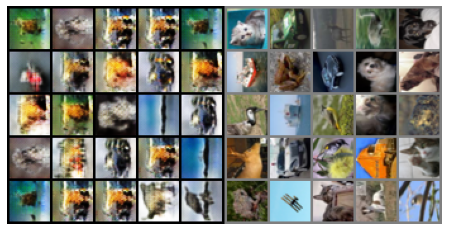

In [18]:
fig = plt.figure(figsize=(12,4))
plt.axis("off")  
pls = [[plt.imshow(norm_grid(im), animated=True)] for im in ims]
ani = animation.ArtistAnimation(fig, pls, interval=500, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# Plot a lot of generated images

random_ohe = Variable(Tensor(np.eye(n_classes)[np.random.choice(n_classes, 100)])).to(device)
# Sample random points in the latent space
random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (100, latent_dim)))).to(device)
# Decode them to fake images, through the generator
generator.to(device)
generated_images = generator(random_latent_vectors, random_ohe)

In [ ]:
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(generated_images, padding=2, normalize=False, nrow=10).cpu())